In [11]:
import dill
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB

In [12]:
def save_pkl(df, filename):
    with open('data/'+filename+'.pkl','wb') as fobj:
        dill.dump(df,fobj)
    
def load_pkl(filename):
    with open('data/'+filename+'.pkl','rb') as fobj:
        df = dill.load(fobj)
    return df

In [13]:
data = load_pkl('labeled_df')

In [4]:
data.iloc[:5]

,genre,lyrics,orig_index,track_id
0,rock,Gimme your body\nGimme your mind\nOpen your he...,0,0FkFTZOJ5Dt4RG4gAWB74z
1,rock,"She doesn't need money, she doesn't need diamo...",1,5J82Xmm1hLcoEhm3volpKr
2,rock,When you open your eyes\nTo a brand new mornin...,2,1OeHbFNw1OV4zFH7XzaeI9
3,rock,I'm a clockwork creep\nAnd I can't get to slee...,3,2wJ3sbNqiINIRW3beIqQUe
4,rock,Oh Donna\nYou made me stand up\nYou made me si...,4,5zd2y6lNhYIazfOPbOo8pq


## MNB predictions

In [105]:
mnb_clf = load_pkl('mnb_notparedData')

In [77]:
actual_genre = []

for i in range(len(data)):
    if data.iloc[i]['genre']=='rock':
        actual_genre.append('Rock')
    if data.iloc[i]['genre']=='hiphop':
        actual_genre.append('Hip-Hop')
    if data.iloc[i]['genre']=='country':
        actual_genre.append('Country')
    lyrics = data.iloc[i]['lyrics']

In [56]:
mnb_clf.named_steps['cnb'].class_log_prior_

array([-1.09861229, -1.09861229, -1.09861229])

In [106]:
result_list = mnb_clf.predict_proba(data['lyrics'])

trans_matrix = np.array([[0, 0.433], [0.5, -0.433], [-0.5, -0.433]])

result_coords = np.matmul(result_list, trans_matrix)

In [58]:
print(actual_genre[:10])

['Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock']


In [107]:
coord_df = pd.DataFrame(result_coords, columns = ['x','y'])
cat_df = pd.DataFrame(actual_genre, columns = ['genre'])
data_df = pd.concat([coord_df, cat_df], axis=1)

In [32]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [108]:
rock_data = data[data['genre']=='rock']
hiphop_data = data[data['genre']=='hiphop']
country_data = data[data['genre']=='country']

In [109]:
rock_predict = mnb_clf.predict_proba(rock_data['lyrics'])
hiphop_predict = mnb_clf.predict_proba(hiphop_data['lyrics'])
country_predict = mnb_clf.predict_proba(country_data['lyrics'])

In [110]:
print(len(rock_predict))
print(len(hiphop_predict))
print(len(country_predict))

13725
7230
3321


In [111]:
rock_tot = len(rock_predict)
hiphop_tot = len(hiphop_predict)
country_tot = len(country_predict)
x = list(range(0,101))
rock_cdf = np.zeros(101)
hiphop_cdf = np.zeros(101)
country_cdf = np.zeros(101)
for prct in x:
    rock_cdf[prct] = sum(rock_predict[:,2]>=(prct*0.01)) / rock_tot
    hiphop_cdf[prct] = sum(hiphop_predict[:,1]>=(prct*0.01)) / hiphop_tot
    country_cdf[prct] = sum(country_predict[:,0]>=(prct*0.01)) / country_tot

In [64]:
sum(country_predict[:,0]<=0.3) / country_tot

0.007527853056308341

In [94]:
percentile_list = pd.DataFrame(
    {'Percent': x,
     'Rock': rock_cdf,
     'Hip-Hop': hiphop_cdf,
     'Country': country_cdf
    })
percentile_list = percentile_list.set_index('Percent')

In [112]:

sampled_df = data_df.sample(n=5000)


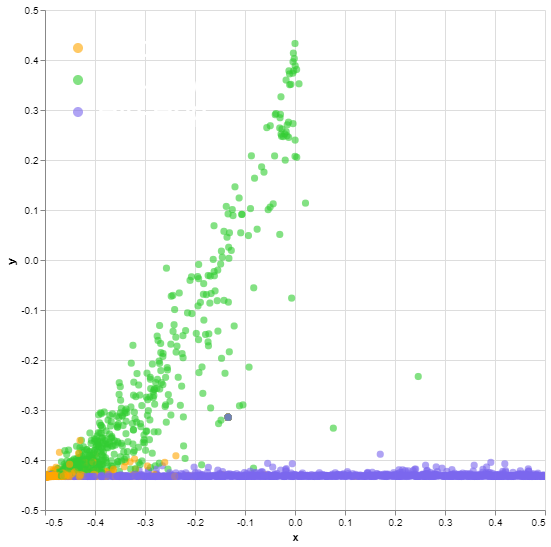

In [113]:
domain = ['Rock', 'Country', 'Hip-Hop']
range_ = ['orange', 'limegreen', 'mediumslateblue']

# A dropdown filter
genre_dropdown = alt.binding_select(options=['Rock', 'Country', 'Hip-Hop'])
genre_select = alt.selection_single(fields=['genre'], bind=genre_dropdown, name=" ")

color=alt.condition(genre_select,
                    alt.Color('genre:N', scale=alt.Scale(domain=domain, range=range_)),
                    alt.value('lightgray'),
                    legend=alt.Legend(labelFontSize=20))

scatter=alt.Chart(sampled_df).mark_circle(opacity=0.6, size=50).encode(
    alt.X('x'),#, axis=None),
    alt.Y('y'),#, axis=None),
    color=color,
).interactive().add_selection(
    genre_select
).configure_view(
    strokeOpacity=0
).configure_legend(
    labelColor='white',
    orient='top-left',
    labelFontSize=30,
    titleFontSize=0,
    titleColor="black"
).properties(
    width=500,
    height=500
)



scatter

In [17]:
scatter.save("prediction_chart2.json")

## CNB Predictions

In [27]:
cnb_clf = load_pkl('cnb_classifier5')
result_list = cnb_clf.predict_proba(data['lyrics'])

cnb_result_coords = np.matmul(result_list, trans_matrix)

In [28]:
cnb_coord_df = pd.DataFrame(cnb_result_coords, columns = ['x','y'])
cnb_data_df = pd.concat([cnb_coord_df, cat_df], axis=1)

cnb_rock_predict = cnb_clf.predict_proba(rock_data['lyrics'])
cnb_hiphop_predict = cnb_clf.predict_proba(hiphop_data['lyrics'])
cnb_country_predict = cnb_clf.predict_proba(country_data['lyrics'])

In [22]:
# rock_tot = len(rock_predict)
# hiphop_tot = len(hiphop_predict)
# country_tot = len(country_predict)
# x = list(range(0,101))
# rock_cdf = np.zeros(101)
# hiphop_cdf = np.zeros(101)
# country_cdf = np.zeros(101)
# for prct in x:
#     rock_cdf[prct] = sum(rock_predict[:,2]>=(prct*0.01)) / rock_tot
#     hiphop_cdf[prct] = sum(hiphop_predict[:,1]>=(prct*0.01)) / hiphop_tot
#     country_cdf[prct] = sum(country_predict[:,0]>=(prct*0.01)) / country_tot
    
cnb_sampled_df = data_df.sample(n=3000)


In [30]:
cnb_clf.named_steps

{'ctvect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=0.9, max_features=None, min_df=0,
                 ngram_range=(1, 2), preprocessor=None,
                 stop_words=frozenset({'instrumental', 'chorus', 'verse'}),
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'tfidf_trans': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True),
 'cnb': ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=False)}

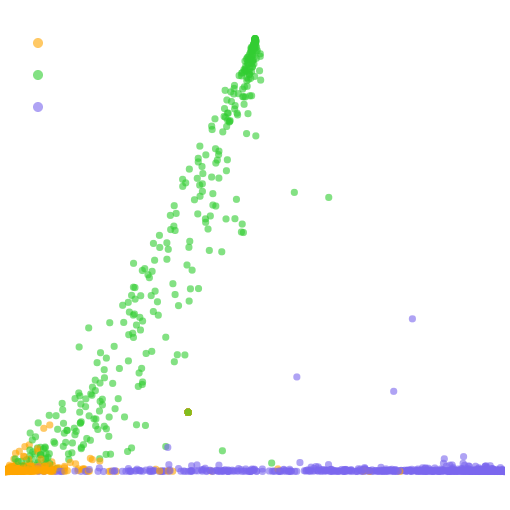

In [29]:



domain = ['Rock', 'Country', 'Hip-Hop']
range_ = ['orange', 'limegreen', 'mediumslateblue']

# A dropdown filter
genre_dropdown = alt.binding_select(options=['Rock', 'Country', 'Hip-Hop'])
genre_select = alt.selection_single(fields=['genre'], bind=genre_dropdown, name=" ")

color=alt.condition(genre_select,
                    alt.Color('genre:N', scale=alt.Scale(domain=domain, range=range_)),
                    alt.value('lightgray'),
                    legend=alt.Legend(labelFontSize=20))

scatter=alt.Chart(cnb_sampled_df).mark_circle(opacity=0.6, size=50).encode(
    alt.X('x', axis=None),
    alt.Y('y', axis=None),
    color=color,
).interactive().add_selection(
    genre_select
).configure_view(
    strokeOpacity=0
).configure_legend(
    labelColor='white',
    orient='top-left',
    labelFontSize=30,
    titleFontSize=0,
    titleColor="black"
).properties(
    width=500,
    height=500
)



scatter

In [18]:
import json
with open("prediction_chart.json", "rb") as f:
    j = json.load(f)
    #print(j)
    print(json.dumps(j, indent=2))

{
  "config": {
    "view": {
      "width": 400,
      "height": 300,
      "strokeOpacity": 0
    },
    "mark": {
      "tooltip": null
    },
    "legend": {
      "labelColor": "white",
      "labelFontSize": 30,
      "orient": "top-left",
      "titleColor": "black",
      "titleFontSize": 0
    }
  },
  "data": {
    "name": "data-1740708203ad9de5a6809c1ed529c911"
  },
  "mark": {
    "type": "circle",
    "opacity": 0.6,
    "size": 50
  },
  "encoding": {
    "color": {
      "value": "lightgray",
      "condition": {
        "type": "nominal",
        "field": "genre",
        "scale": {
          "domain": [
            "Rock",
            "Country",
            "Hip-Hop"
          ],
          "range": [
            "orange",
            "limegreen",
            "mediumslateblue"
          ]
        },
        "selection": " "
      }
    },
    "x": {
      "type": "quantitative",
      "axis": null,
      "field": "x"
    },
    "y": {
      "type": "quantitative",
     

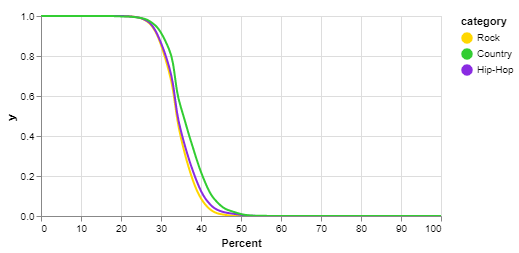

In [95]:
import altair as alt
import pandas as pd
import numpy as np

domain = ['Rock', 'Country', 'Hip-Hop']
range_ = ['gold', 'limegreen', 'blueviolet']

np.random.seed(42)
source = percentile_list
source = source.reset_index().melt('Percent', var_name='category', value_name='y')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Percent'], empty='none')

# The basic line
line = alt.Chart(source).mark_line(interpolate='basis').encode(
    x='Percent:Q',
    y='y:Q',
    color=alt.Color('category', scale=alt.Scale(domain=domain, range=range_))
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(source).mark_point().encode(
    x='Percent:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'y:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(source).mark_rule(color='gray').encode(
    x='Percent:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=400, height=200
)